### Analyzing Polarization Data v4
Using the method in the paper 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import scipy.odr as odr
np.set_printoptions(4)

### Define the Functions for Analyzing Polarization Data

In [2]:

# Define the fitting function
def I(k, t):
    # fitting parameters
    # k0 - DC level
    # k1 - amplitude of the sin(2pi) component
    # k2 - amplitude of sin(4pi) component
    # k3 - amplitude of cos(4pi) component
    # k4 - the period of the data
    I = 0.5 * (k[0] + k[1] * np.sin(4 * np.pi * t / k[4]) + \
               k[2] * np.cos(8 * np.pi * t / k[4]) + \
               k[3] * np.sin(8 * np.pi * t / k[4]))
    return I

# function to analyze the data
def polarizationAnalyze(fileName):
    msgs = []

    # get comments from file
    fpData = open(fileName, 'r')
    for line in fpData:
        if line[0] == '#':
            msgs.append(line.strip())
    # get the data
    data = np.loadtxt(fileName, delimiter=",")
    msgs.append("There are %d data points in %s" % (len(data), fileName))
    
    # Guess some starting values
    dataAvg = np.average(data[:,1])
    dataRange = max(data[:,1]) - min(data[:,1])
    maxTime = max(data[:,0])
    k = np.array((dataAvg,0.25*dataRange, 0.25*dataRange, 0.25*dataRange, maxTime))
    msgs.append("Initial k =\n"+str(k))
    
    # Set up and do the fit
    kGuess = k
    fitModel = odr.Model(I) # declare the fitting function
    fitData = odr.RealData(data[:,0], data[:,1], 0.005, 0.01 * dataRange)
    myOdr = odr.ODR(fitData, fitModel, beta0=kGuess)
    output = myOdr.run()
    k = output.beta
    kDel = output.sd_beta
    
    # Print results to strings
    msgs.append("Fitted parameters = \n"+str(k))
    msgs.append("Parameter Errors = \n"+str(kDel))
    
    # Compute polarization parameters
    S = np.array((k[0] - k[2], 2 * k[2], 2 * k[3], k[1]))
    (I0, Q, U, V) = S
    SDel = np.array((np.sqrt(kDel[0]**2+kDel[3]**2), 2*kDel[2], 2*kDel[3], kDel[1]))
    SNorm = S / S[0]
    SNormDel = np.array((0, SNorm[1]*np.sqrt((SDel[1]/S[1])**2+(SDel[0]/S[0])**2), \
                        SNorm[2]*np.sqrt((SDel[2]/S[2])**2+(SDel[0]/S[0])**2), \
                        SNorm[3]*np.sqrt((SDel[3]/S[3])**2+(SDel[0]/S[0])**2)))

    # Calculate parameters for the polarization ellipse
    Ip = np.sqrt(sum(x**2 for x in SNorm[1:]))
    LMag = np.sqrt(sum(x**2 for x in SNorm[1:3]))
    IpDel = Ip * np.sqrt(sum(x**2 for x in SNormDel[1:]/SNorm[1:]))
    LMagDel = LMag * np.sqrt(sum(x**2 for x in SNormDel[1:3]/SNorm[1:3]))
    
    # Ellipse parameters
    A = np.sqrt(0.5 * (Ip + LMag))
    B = np.sqrt(0.5 * (Ip - LMag))
    theta = 0.5 * np.arctan2(U, Q)
    thetaD = 180 * theta / np.pi
    h = np.sign(V)
    polarization = np.array([Ip, V, theta])
    ellipse = np.array((A, B, theta, h))
    msgs.append("S = \n" + str(S))
    msgs.append("SNormalized = \n" + str(SNorm))
    msgs.append("SNormalized Uncertainties = \n" + str(SNormDel))
    msgs.append("Polarization parameters = \n" + str(polarization))
    msgs.append("Ellipse paramters = \n" + str(ellipse))
    
    msgs.append("Done")
    return (data, k, kDel, SNorm, SNormDel, polarization, ellipse, msgs)

In [3]:
import glob
names = []
for name in glob.glob('*.csv'):
    names.append(name.strip())
names.sort()
for name in names:
    print name
fileName = raw_input("Enter file name:")
baseName = fileName[:fileName.rfind('.')]
print "fileName= ", fileName

MEH-PartLC.csv
Enter file name:MEH-PartLC.csv
fileName=  MEH-PartLC.csv


### Read in the Data
The first file is linearly polarized light passing through a cuvette of undiluted Karo syrup. The second file is an analysis of the laser light that should be very close to 100% linearly polarized.

In [4]:
output = polarizationAnalyze(fileName)
for msg in output[-1]:
    print ">%s<" % (msg)
data = output[0]
k = output[1]

># 1/2 polarised 22.5deg + RCP0.000, 0.645<
>There are 999 data points in MEH-PartLC.csv<
>Initial k =
[ 0.5723  0.1037  0.1037  0.1037  6.283 ]<
>Fitted parameters = 
[ 1.1445  0.289   0.1445  0.1445  6.28  ]<
>Parameter Errors = 
[  1.9173e-05   2.6885e-05   3.1782e-05   3.3677e-05   6.2749e-05]<
>S = 
[ 1.     0.289  0.289  0.289]<
>SNormalized = 
[ 1.     0.289  0.289  0.289]<
>SNormalized Uncertainties = 
[  0.0000e+00   6.4542e-05   6.8280e-05   2.9125e-05]<
>Polarization parameters = 
[ 0.5006  0.289   0.3927]<
>Ellipse paramters = 
[ 0.6743  0.2143  0.3927  1.    ]<
>Done<


----
### Plot the data, fit, and ellipse

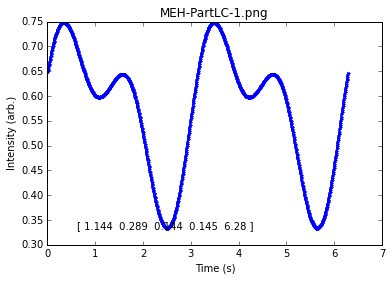

In [5]:
plt.plot(data[:,0],data[:,1], '.')
tFcn = np.linspace(min(data[:,0]), max(data[:,0]), 1000)
plt.plot(tFcn, I(k, tFcn), 'b-')
ax1 = plt.gca()
yPlot = 1*min(data[:,1]) +0*max(data[:,1])
xPlot = .1*max(data[:,0])
np.set_printoptions(precision=3)
ax1.axes.text(xPlot,yPlot,str(k))
figName = "%s-1.png" % (baseName)
plt.title(figName)
plt.xlabel('Time (s)')
plt.ylabel("Intensity (arb.)")
plt.savefig(figName)

### Plot Ellipse

(A, B, theta, h)= 0.674256927804 0.214312006946 0.392741670779 1.0


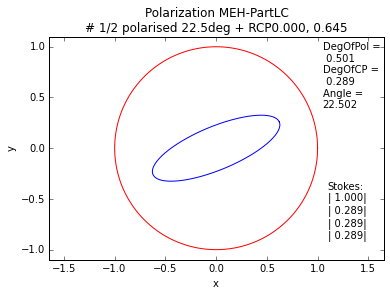

In [6]:
# Make Ellipse Data
(A, B, theta, h) = output[6]
print "(A, B, theta, h)=", A, B, theta, h
phi = np.linspace(0, 2 * np.pi, 1000)
cosTh = np.cos(theta)
sinTh = np.sin(theta)
xPrime = A * np.cos(phi)
yPrime = B * np.sin(phi)
x = np.cos(theta) * xPrime - np.sin(theta) * yPrime
y = np.sin(theta) * xPrime + np.cos(theta) * yPrime

plt.plot(x, y, 'b-')
plt.plot(np.cos(phi), np.sin(phi), 'r-')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.axes().set_aspect('equal', 'datalim')
plt.title("Polarization %s\n%s" % (baseName, output[7][0]))
plt.xlabel("x")
plt.ylabel("y")
S = output[3]
plt.text(1.1, -0.9, "Stokes:\n| 1.000|\n|%6.3f|\n|%6.3f|\n|%6.3f|" % \
        (S[1],S[2],S[3]))
plt.text(1.05, 0.4, "DegOfPol =\n%6.3f\nDegOfCP =\n%6.3f\nAngle =\n%6.3f" % \
        (np.sqrt(S[1]**2+S[2]**2+S[3]**2)/S[0], \
         abs(S[3]), 180*theta/np.pi))
figName = "%s-2.png" % (baseName)
plt.savefig(figName)

In [7]:
print output[7][0]

# 1/2 polarised 22.5deg + RCP0.000, 0.645


In [8]:
print np.sqrt(.5**2+.5**2+.707**2)

0.99992449715
